### This is the Exploratory Data Analysis notebook for the paper machine sheet break dataset listed below.

#### Business Case
Identifying an impending process interuption, fault or failure in advance to warn operators to take remedial action, or program the process control system to take a different action than maintaining readings within set point ranges may reduce the number of process interuptions, thus improving production and reducing costs.

#### Assumptions
1. Process variation within set point limits or specific or correlated deviation by a subset of measurements may provide advance indication of an upcoming failure.
2. Some, but not all sheet breaks may occur due to rapid deviation in a control point or an external issue such as a power failure, auxiliary equipment failure, or human intervention - some type of emergency shut down.
3. Other sheet breaks may result from a combined effect of two or several process measurements where the deviation of each is within limits, but the combined effect leads to a sheet break.  Otherwise the proces control if running within set limits should prevent a sheet break.  If the assumption of combined deviation does not hold, then most sheet breaks are a result of some variation of auxhiliary equipment mal-function that the process control system cannot correct. 

### Reference and Dataset Licence

### Dataset: Rare Event Classification in Multivariate Time Series
 ### 2018-10-01  Chitta Ranjan, Markku Mustonen, Kamran Paynabar, Karim Pourak
### https://deeplearn.org/arxiv/48599/dataset:-rare-event-classification-in-multivariate-time-series

### EDA
    - Import dataset & view data feature types and info
    - Explore integer / categorical features
    - Plot feature distributions for normal (0) and sheet break (1) conditions
    - Add a new feature category labelling time samples ahead of the actual break and investigate feature variation
    - Do a preliminary feature importance using Random Forest Classsifier using the new labels.

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df=pd.read_csv('processminer-rare-event-mts - data.csv')

In [3]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

The df.info() report below shows two possible categorical features:  x28 and x61

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 63 columns):
time    18398 non-null datetime64[ns]
y       18398 non-null int64
x1      18398 non-null float64
x2      18398 non-null float64
x3      18398 non-null float64
x4      18398 non-null float64
x5      18398 non-null float64
x6      18398 non-null float64
x7      18398 non-null float64
x8      18398 non-null float64
x9      18398 non-null float64
x10     18398 non-null float64
x11     18398 non-null float64
x12     18398 non-null float64
x13     18398 non-null float64
x14     18398 non-null float64
x15     18398 non-null float64
x16     18398 non-null float64
x17     18398 non-null float64
x18     18398 non-null float64
x19     18398 non-null float64
x20     18398 non-null float64
x21     18398 non-null float64
x22     18398 non-null float64
x23     18398 non-null float64
x24     18398 non-null float64
x25     18398 non-null float64
x26     18398 non-null float64
x27     18398 non-

#### Determine the number of sheet break (y = 1) and the time range and examine the nature of x28 and x61 features.

In [6]:
df['y'].value_counts()

0    18274
1      124
Name: y, dtype: int64

In [7]:
print('Earliest timestamp is ',min(df['time']), ' and the latest tiemstampe is ', max(df['time']) )

Earliest timestamp is  1999-05-01 00:00:00  and the latest tiemstampe is  1999-05-29 00:06:00


There are 124 sheet breaks from midnight on May 1 to 6am on May 29th 1999.  We can see from the df.head() output above that the samples are 2 minutes apart during a running condition.

#### Feature x28

In [8]:
x28_vals = df['x28'].unique()
x28_vals

array([ 96,  93, 118, 112,  82,  84, 139,  51], dtype=int64)

In [9]:
df['x28'].value_counts()

96     6574
82     4378
118    2646
139    1807
84     1313
112    1235
93      419
51       26
Name: x28, dtype: int64

In [10]:
print(('{:<12}{:<4}{:<18}{:<4}{:<10}').format('x28 value ', 'y', 'value counts', 'y', 'value counts'))
for val in x28_vals:
    y_vcs = df['y'][df['x28']==val].value_counts()
    print(('{:^12}{:<2}{:^20}{:<2}{:^14}').format(val, 0 , y_vcs[0], 1 , y_vcs[1]))

x28 value   y   value counts      y   value counts
     96     0         6502        1       72      
     93     0         418         1       1       
    118     0         2631        1       15      
    112     0         1230        1       5       
     82     0         4360        1       18      
     84     0         1311        1       2       
    139     0         1797        1       10      
     51     0          25         1       1       


The graph below shows that the values in the x28 feature are in themselves not clearly related to sheet breaks.  This feature maybe some type of global set value such as the paper weight and could be related to different set point ranges for particular process variables.  Consider retaining this feature and use One Hot Encoding. 
Many of the sheet breaks occur in rapid succession, likely mutliple failures during start-up.  Also, there are some short time gaps and one large time period sample gap on May 17th or 18th.  This may be missing data or a planned shutdown.  The second anf third chart below show the same samples by time and sample number on May 1st.  'y' is only 1 or 0, the sloped line on the time chart is connecting two consecutive samples.

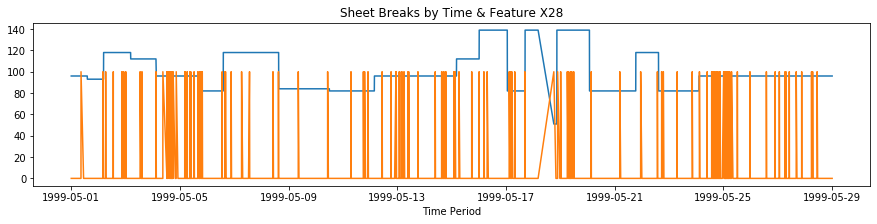

In [11]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x28'])
plt.plot(df['time'], df['y']*100)
plt.title("Sheet Breaks by Time & Feature X28")
plt.xlabel('Time Period')
plt.show()

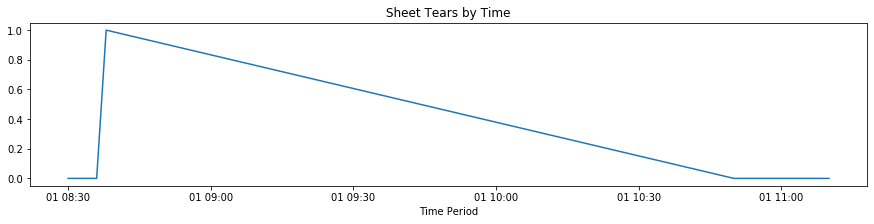

In [12]:
plt.figure(figsize=(15,3))
plt.plot(df['time'].loc[30*8.5:30*9], df['y'].loc[30*8.5:30*9])
plt.title("Sheet Tears by Time")
plt.xlabel('Time Period')
plt.show()

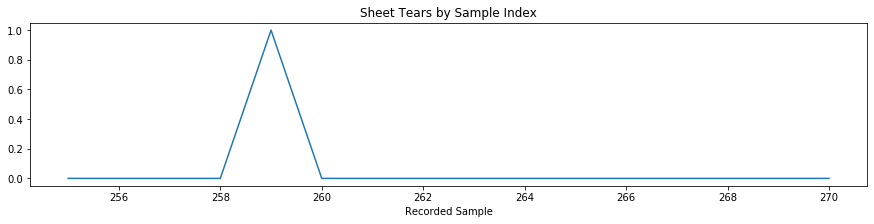

In [13]:
plt.figure(figsize=(15,3))
plt.plot(df['y'].loc[30*8.5:30*9])
plt.title("Sheet Tears by Sample Index")
plt.xlabel('Recorded Sample')
plt.show()

#### Feature x61

In [14]:
print('x61 unique values')
df['x61'].unique()

x61 unique values


array([0, 1], dtype=int64)

In [15]:
print('x61 value counts')
df['x61'].value_counts()

x61 value counts


0    18379
1       19
Name: x61, dtype: int64

In [16]:
print('"y" values when x61 is equal to 1')
df['y'][df['x61']==1].value_counts()

"y" values when x61 is equal to 1


1    19
Name: y, dtype: int64

Feature x61 is only 1 when y is 1, but only in 19 samples.  This may be a manual shutdown flag.  This can be seen in the chart below where the value of x61 is multiplied by 2 to be visible amoung the y values of 1 

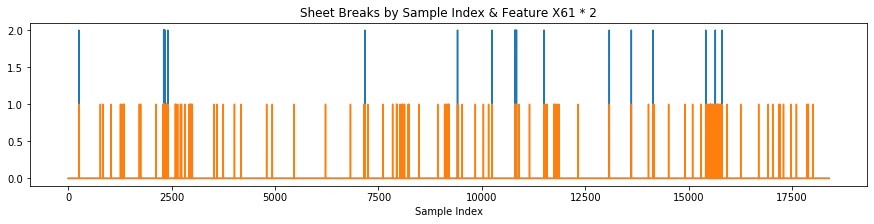

In [17]:
plt.figure(figsize=(15,3))
#plt.plot(df['time'], df['x61']*2)
#plt.plot(df['time'], df['y'])
plt.plot( df['x61']*2)
plt.plot( df['y'])
plt.title("Sheet Breaks by Sample Index & Feature X61 * 2")
plt.xlabel('Sample Index')
#plt.xlim(250,1000)
plt.show()

#### Feature Distributions:
The feature distributions for y=0 and y=1 and shown below.

Some features are fairly well aligned for normal and failure conditions like x5, x6, and x7 among others.  The outliers in these distributions may be related to pre-failure conditions.  
Some features show marked differences between normal and failure startes like x2, x3, an x29.  Again, outlier values may be assoicated with pre-failure conditions.
Some feature display mutliple peaks which may be associated with differences in feature x28, such as features xx21, x23, x33, x44, and x52.
Some features exhibit very narrow peaks with wide tails.  These may have a categorical nature although with a float value.

These will be examined with correlation mapping on feature subsets and looking at the features with box plots focussing on pre-failure and failure samples.

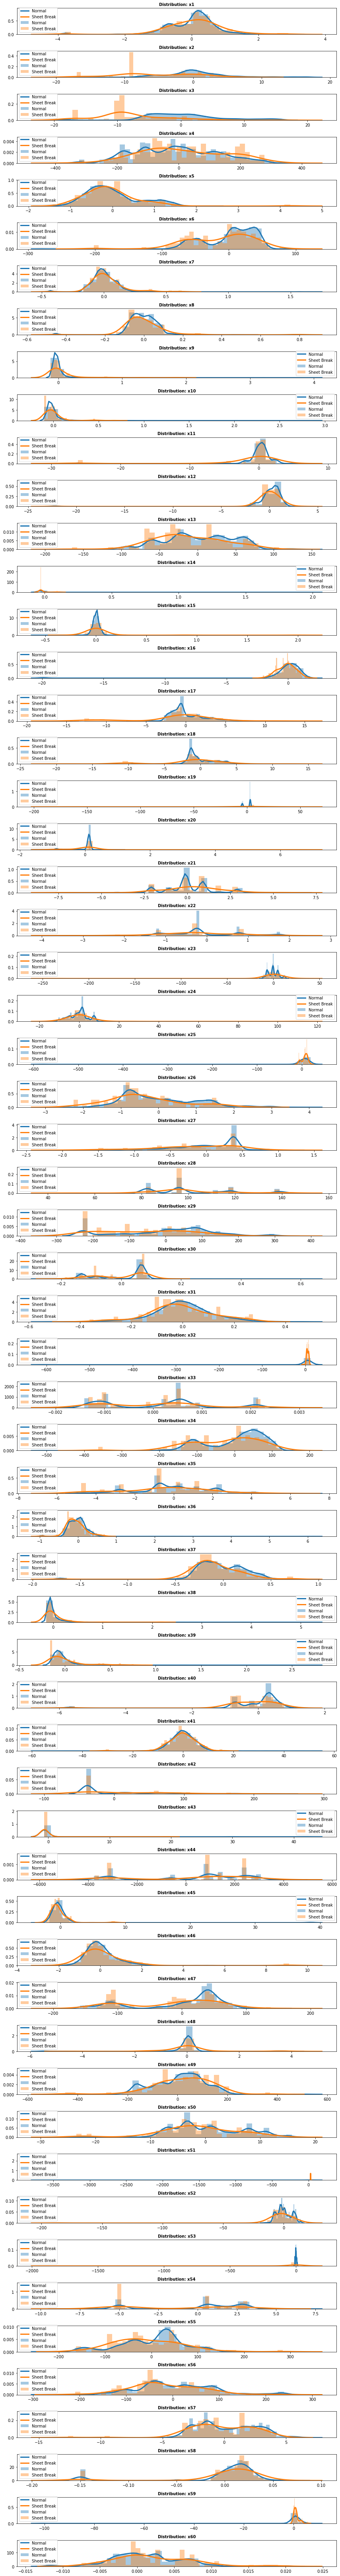

In [18]:
process_features = df.columns[2:62]
plt.figure(figsize=(12,60*1.5))
gs = gridspec.GridSpec(60, 1)

for  i, col_val in enumerate(process_features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[col_val][df['y'] == 0], bins = 40, label = 'Normal',
                 kde_kws={"lw": 3, "label": "Normal"})
    sns.distplot(df[col_val][df['y'] == 1], bins = 40, label = 'Sheet Break',
                 kde_kws={"lw": 3, "label": "Sheet Break"})
    ax.set_title('Distribution: ' + col_val, weight = 'bold', fontsize = 10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('', fontsize = 12)
plt.tight_layout()

### Take a closer look at a few features 

#### Feature x51:   an odd distribution.
This feature shows a majority of values near +40, but with several samples less than -3000. (The first chart show x51 / 3000).

In [19]:
df['x51'].nunique(), min(df['x51']), max(df['x51'])

(2743, -3652.989, 40.1523482)

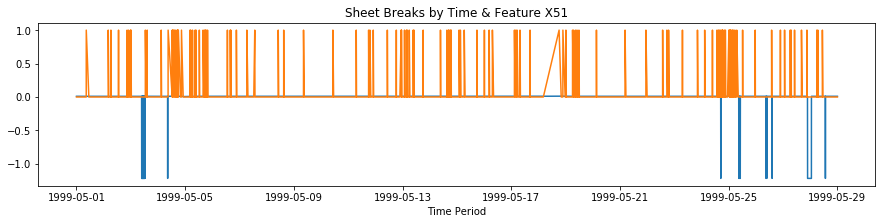

In [20]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x51']/3000)
plt.plot(df['time'], df['y'])
plt.title("Sheet Breaks by Time & Feature X51")
plt.xlabel('Time Period')
plt.show()

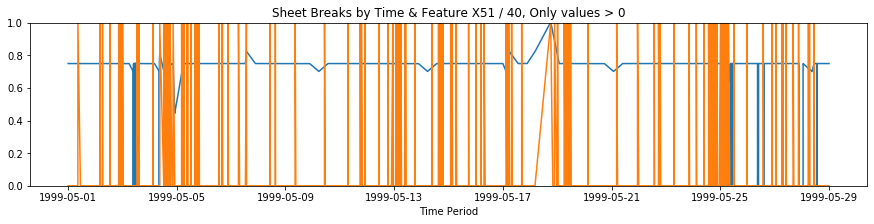

In [21]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x51']/40)
plt.plot(df['time'], df['y'])
plt.title("Sheet Breaks by Time & Feature X51 / 40, Only values > 0")
plt.xlabel('Time Period')
plt.ylim(0,1)
plt.show()

#### Feature x3: Often shows a decline after startup, sometimes ending in a sheet break.

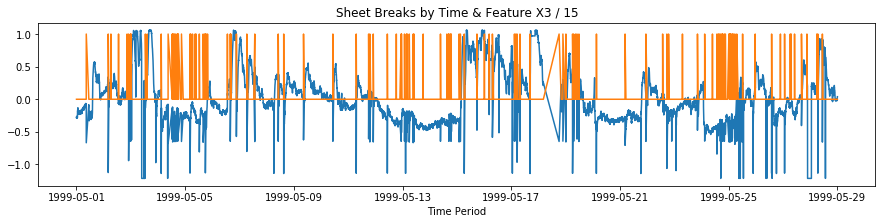

In [22]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x3']/15)

plt.plot(df['time'], df['y'])
#plt.plot(df['time'], df['x12']*10)
plt.title("Sheet Breaks by Time & Feature X3 / 15")
plt.xlabel('Time Period')
plt.show()

#### Feature x53:  There may be a correlation with x28.

In [23]:
df['x53'].nunique(), min(df['x53']), max(df['x53']), len(df[df['x53']<-15])

(10938, -1817.5955, 11.1480061, 1)

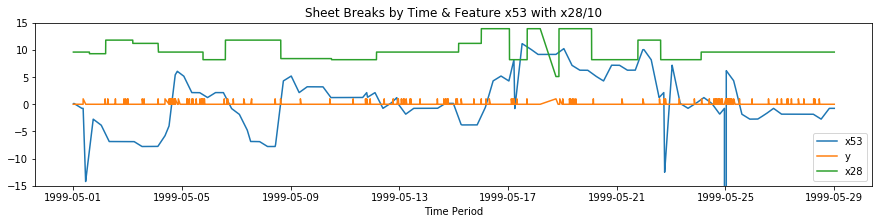

In [24]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x53'], label = 'x53')
plt.plot(df['time'], df['y'], label = 'y')
plt.plot(df['time'], df['x28']/10, label = 'x28')
plt.title("Sheet Breaks by Time & Feature x53 with x28/10")
plt.xlabel('Time Period')
plt.legend()
plt.ylim(-15,15)
plt.show()

#### Feature x52:  There appears to be a correlation with x28.  The x52 values seem to be in blocks aligning with x28 changes.

In [25]:
df['x52'].nunique(), min(df['x52']), max(df['x52']), len(df[df['x52']<-15])

(11257, -187.94343999999998, 14.1805884, 31)

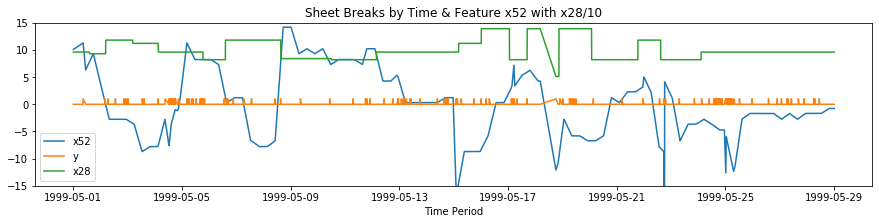

In [26]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x52'], label = 'x52')
plt.plot(df['time'], df['y'], label = 'y')
plt.plot(df['time'], df['x28']/10, label = 'x28')
plt.title("Sheet Breaks by Time & Feature x52 with x28/10")
plt.xlabel('Time Period')
plt.legend()
plt.ylim(-15,15)
plt.show()

### Now look at correlation of select features with x28.  

The upper two plots (below) show thre are interesting correlations between feature x22 with x23 and x35 with y=0 showing hard edges and blocks of operating regions that likely driven by the categorical feature x28.   These regions are not present when y=1.
The lower two plots show some separation of values with feature x28.
Some plots are skewed by outliers.

Next, compare distributions with box plots and label pre-failure samples from 1 to 5, with y=1 as 6.

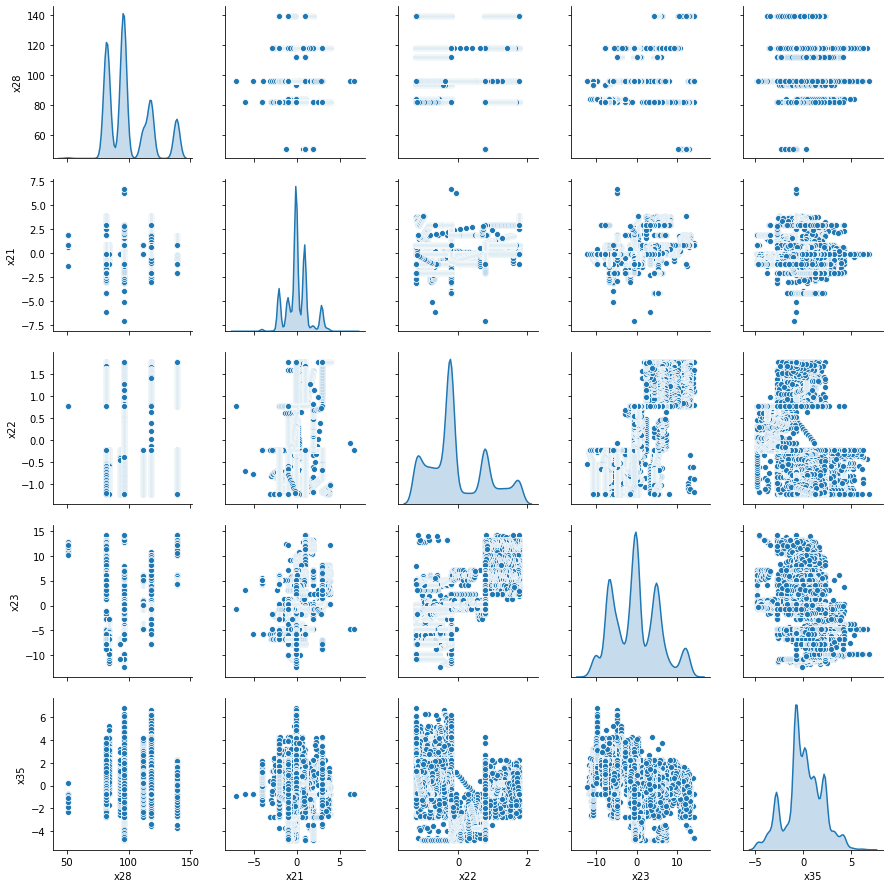

In [27]:
#df_plot = df[['x28','x21', 'x22', 'x23', 'x35', 'x44', 'x50', 'x52', 'x54']][df['y']==0]
df_plot = df[['x28','x21', 'x22', 'x23', 'x35']][df['y']==0]
sns.pairplot(df_plot, diag_kind = "kde",kind = "scatter")
plt.show()

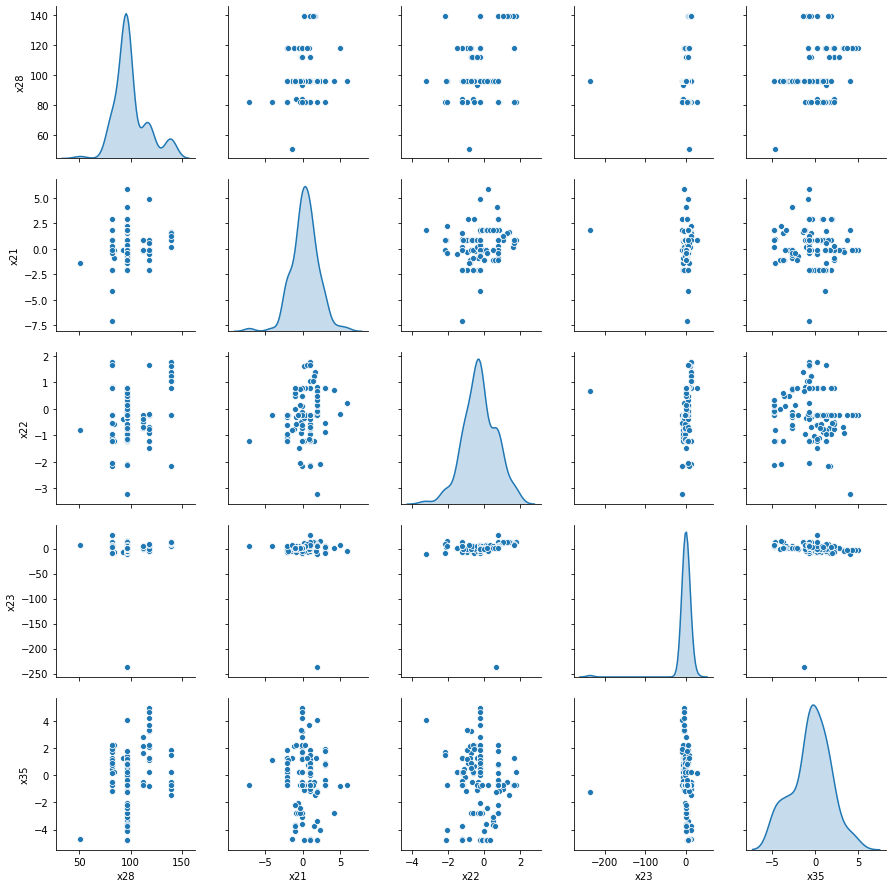

In [28]:
#df_plot_1 = df[['x28','x21', 'x22', 'x23', 'x33', 'x35', 'x44', 'x50', 'x52', 'x54']][df['y']==1]
df_plot_1 = df[['x28','x21', 'x22', 'x23', 'x35']][df['y']==1]
sns.pairplot(df_plot_1, diag_kind = "kde",kind = "scatter")
plt.show()

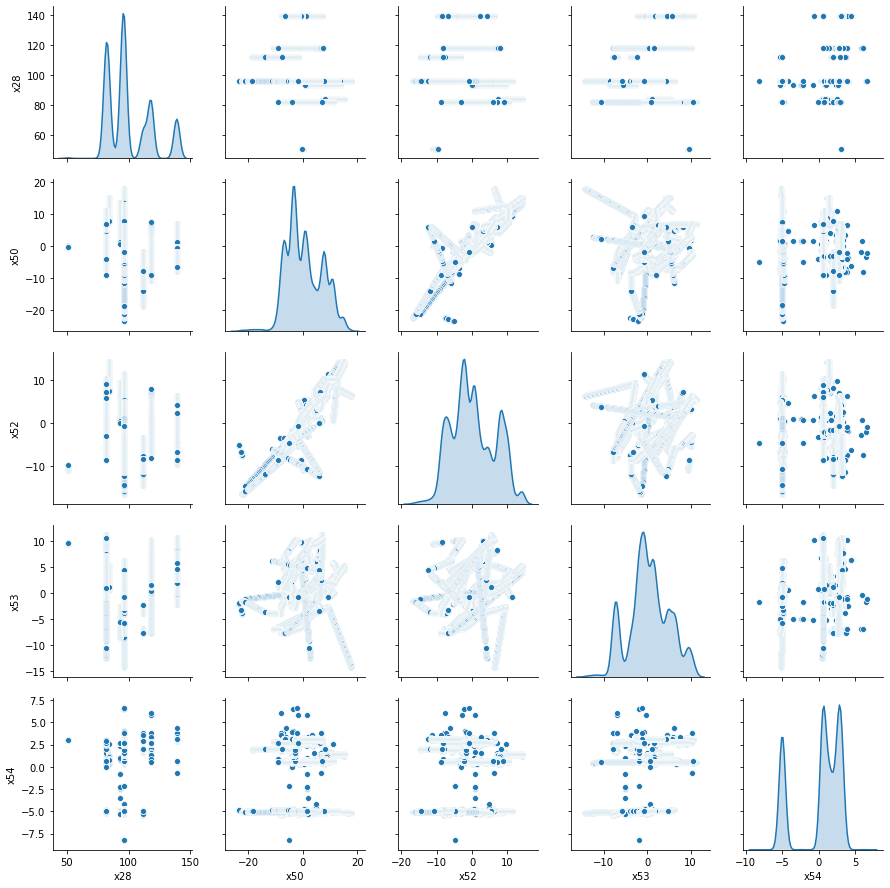

In [29]:
df_plot_2 = df[['x28', 'x50', 'x52', 'x53', 'x54']][df['y']==0]
sns.pairplot(df_plot_2, diag_kind = "kde",kind = "scatter")
plt.show()

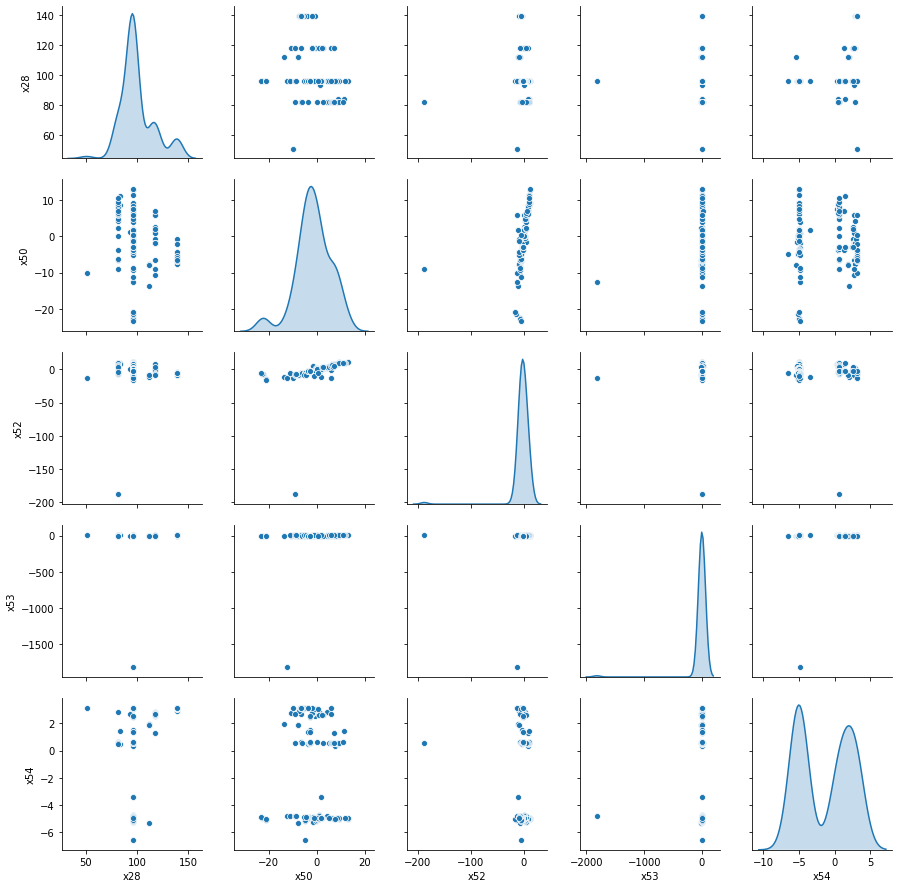

In [30]:
df_plot_3 = df[['x28', 'x50', 'x52', 'x53', 'x54']][df['y']==1]
sns.pairplot(df_plot_3, diag_kind = "kde",kind = "scatter")
plt.show()

### Add labels  1,2,3,4,5 for pre-failure time series: 1 for 5 time increments before the failure, 5 for one time increment before the failure.

In [31]:
breaks = df['y'][df['y']==1].index
df['label'] = 0
for ind in breaks:
    for i in range(6):
        if df['label'][ind - i] == 0:  # avoid relabelling samples from a prior sheet break if they are closer than 6 samples apart
            df['label'][ind - i] = 6 - i 

df['label'][252:261]

252    0
253    0
254    1
255    2
256    3
257    4
258    5
259    6
260    0
Name: label, dtype: int64

In [32]:
df['label'].value_counts()

0    17673
6      124
5      124
4      123
3      122
2      119
1      113
Name: label, dtype: int64

In [33]:
df_stats = pd.DataFrame(columns = process_features)
df_stats = df[process_features].describe()
df_stats

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
count,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,...,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000
mean,0.011824,0.157986,0.569300,-9.958345,0.006518,2.387533,0.001647,-0.004125,-0.003056,-0.002511,...,-3.357339,0.380519,0.360246,0.173708,2.379154,9.234953,0.233493,-0.001861,-0.061522,0.001258
std,0.742875,4.939762,5.937178,131.033712,0.634054,37.104012,0.108870,0.075460,0.156047,0.106526,...,348.256716,6.211598,14.174273,3.029516,67.940694,81.274103,2.326838,0.048732,10.394085,0.004721
min,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,-0.098310,...,-3652.989000,-187.943440,-1817.595500,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.012229
25%,-0.405681,-2.158235,-3.537054,-111.378372,-0.446787,-24.345268,-0.058520,-0.051043,-0.059966,-0.048260,...,29.984624,-3.672684,-1.928166,0.487780,-40.050046,-45.519149,-1.598804,0.000470,0.295023,-0.001805
50%,0.128245,-0.075505,-0.190683,-14.881585,-0.120745,10.528435,-0.009339,-0.000993,-0.030057,-0.018352,...,29.984624,0.294846,0.143612,0.702299,17.471317,1.438806,0.085826,0.012888,0.734591,0.000710
75%,0.421222,2.319297,3.421223,92.199134,0.325152,32.172974,0.060515,0.038986,0.001990,0.011557,...,29.984624,5.109543,3.230770,2.675751,44.093387,63.209681,2.222118,0.020991,1.266506,0.004087
max,3.054156,16.742105,15.900116,334.694098,4.239385,96.060768,1.705590,0.788826,4.060033,2.921802,...,40.152348,14.180588,11.148006,6.637265,287.252017,252.147455,6.922008,0.067249,6.985460,0.020510


The set of box plots below shows that many features do not vary from the normal state, however, some features have a noticable shift in the five samples prior to a sheet break.  Some have a shift in the mean or a shift in the inner quartiles, including features: x6, x13, x29, x34, x36, x37, x40, x42, x44, x47, x52, x54, x55, and x56.

Replot the boxplots but restricting to a single category from x28 to see if there is greater difference for labels 1 through 5.

Compare these noticable features with a feature importance from a random forest classification to reduce training features in models.

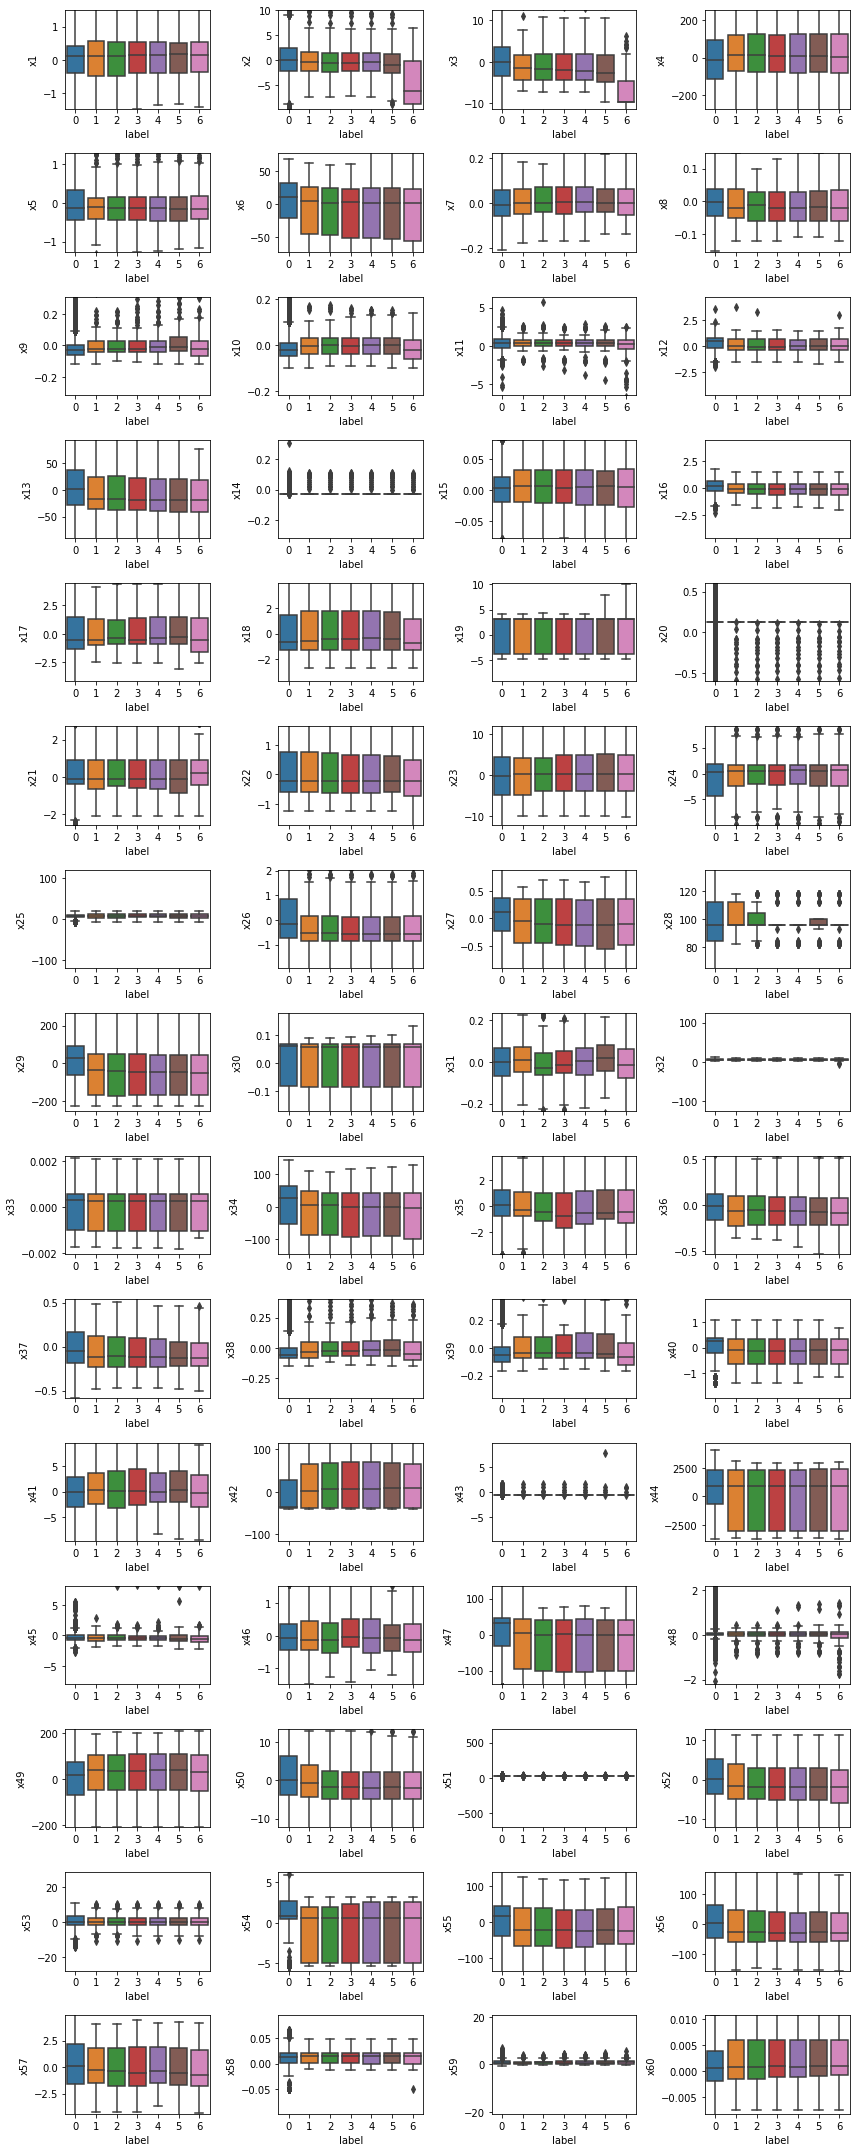

In [34]:
plt.figure(figsize=(12,30))
for i in range(60):
    feature = process_features[i]
    plt.subplot(15,4,i+1)
    plt.grid(False)
    sns.boxplot(df['label'], df[feature], saturation = 0.7)
    plt.ylim(df_stats[feature][1] - 2*df_stats[feature][2], df_stats[feature][1] + 2*df_stats[feature][2])
plt.tight_layout()

### Box Plots with x28 restricted to 96, the most frequent value.
Feature x54 is marketly different than the boxplot for x54 for all values of x28.  x47 also shows greater separation from the normal state with x28 fixed at 96.  Other features also show some noticable difference: x21, x29, x40, x44, and x55. 

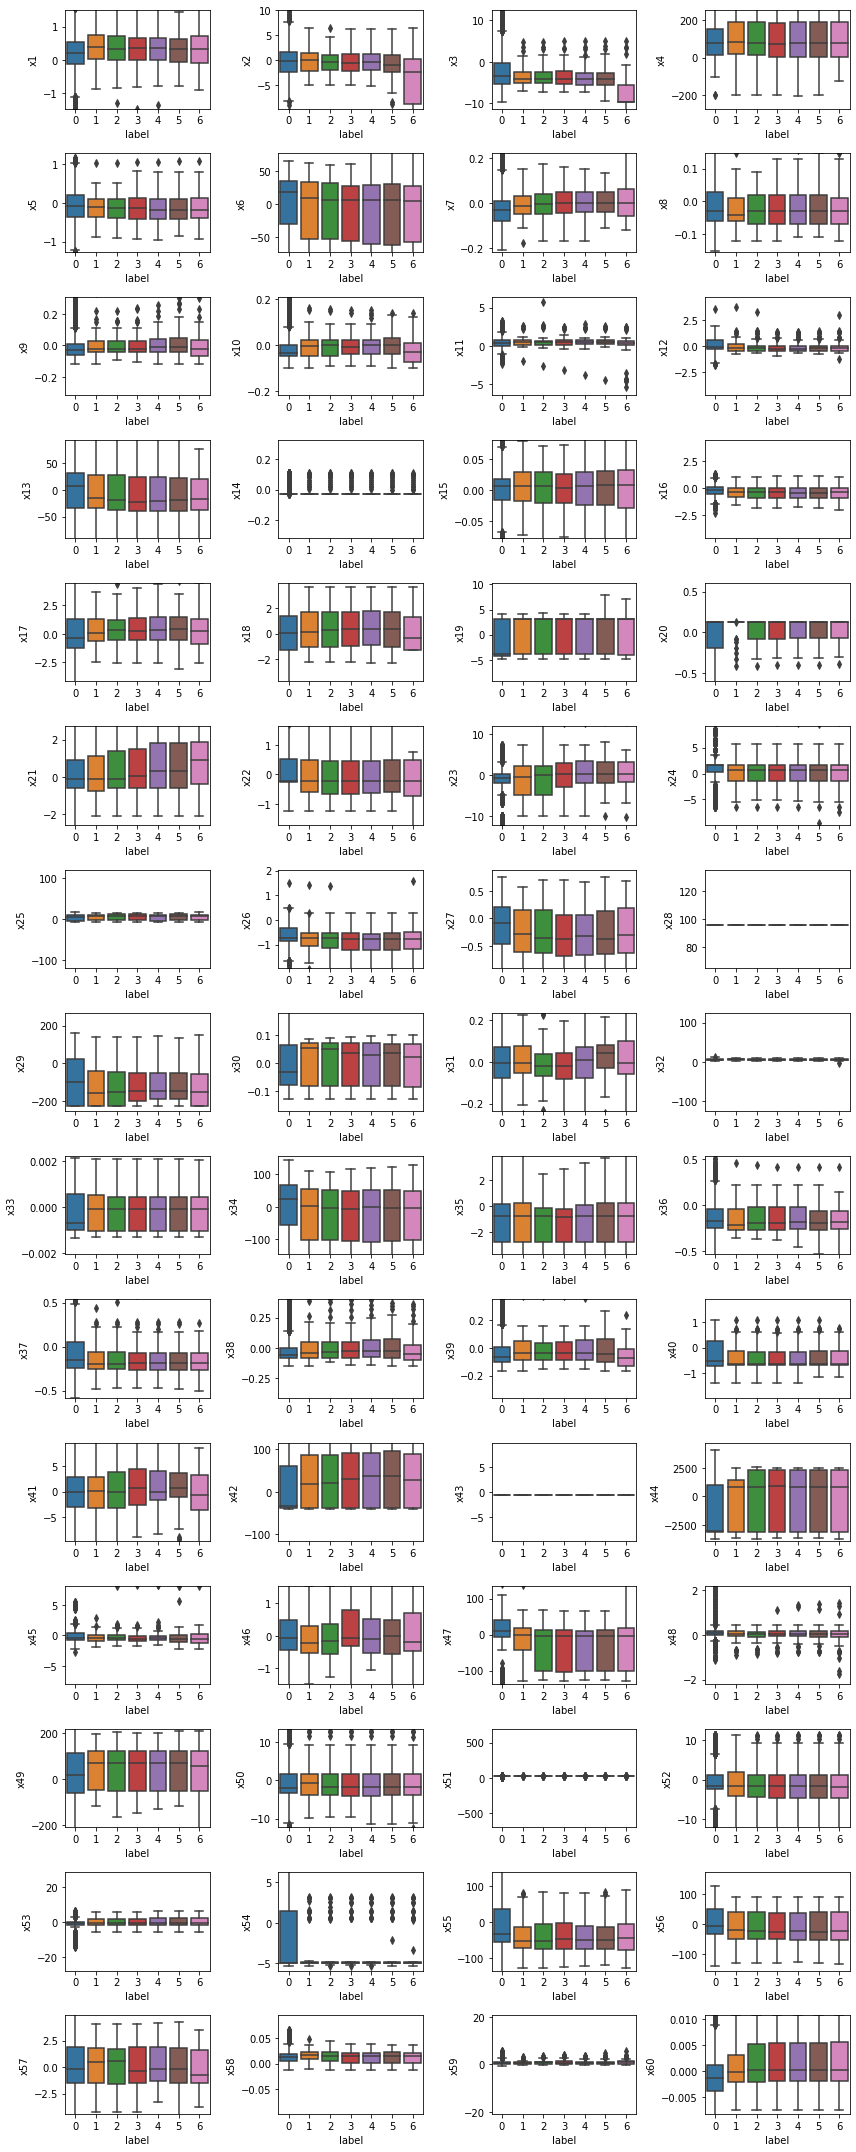

In [35]:
plt.figure(figsize=(12,30))
for i in range(60):
    feature = process_features[i]
    plt.subplot(15,4,i+1)
    plt.grid(False)
    sns.boxplot(df['label'][df['x28']==96], df[feature][df['x28']==96], saturation = 0.7)
    plt.ylim(df_stats[feature][1] - 2*df_stats[feature][2], df_stats[feature][1] + 2*df_stats[feature][2])
plt.tight_layout()

### Box Plot for x28 at 82:
With x28 set at 82, there is a difference in feature x58 for labels 1 through 5.  

Consider building models specific for the set point / category for feature x28.

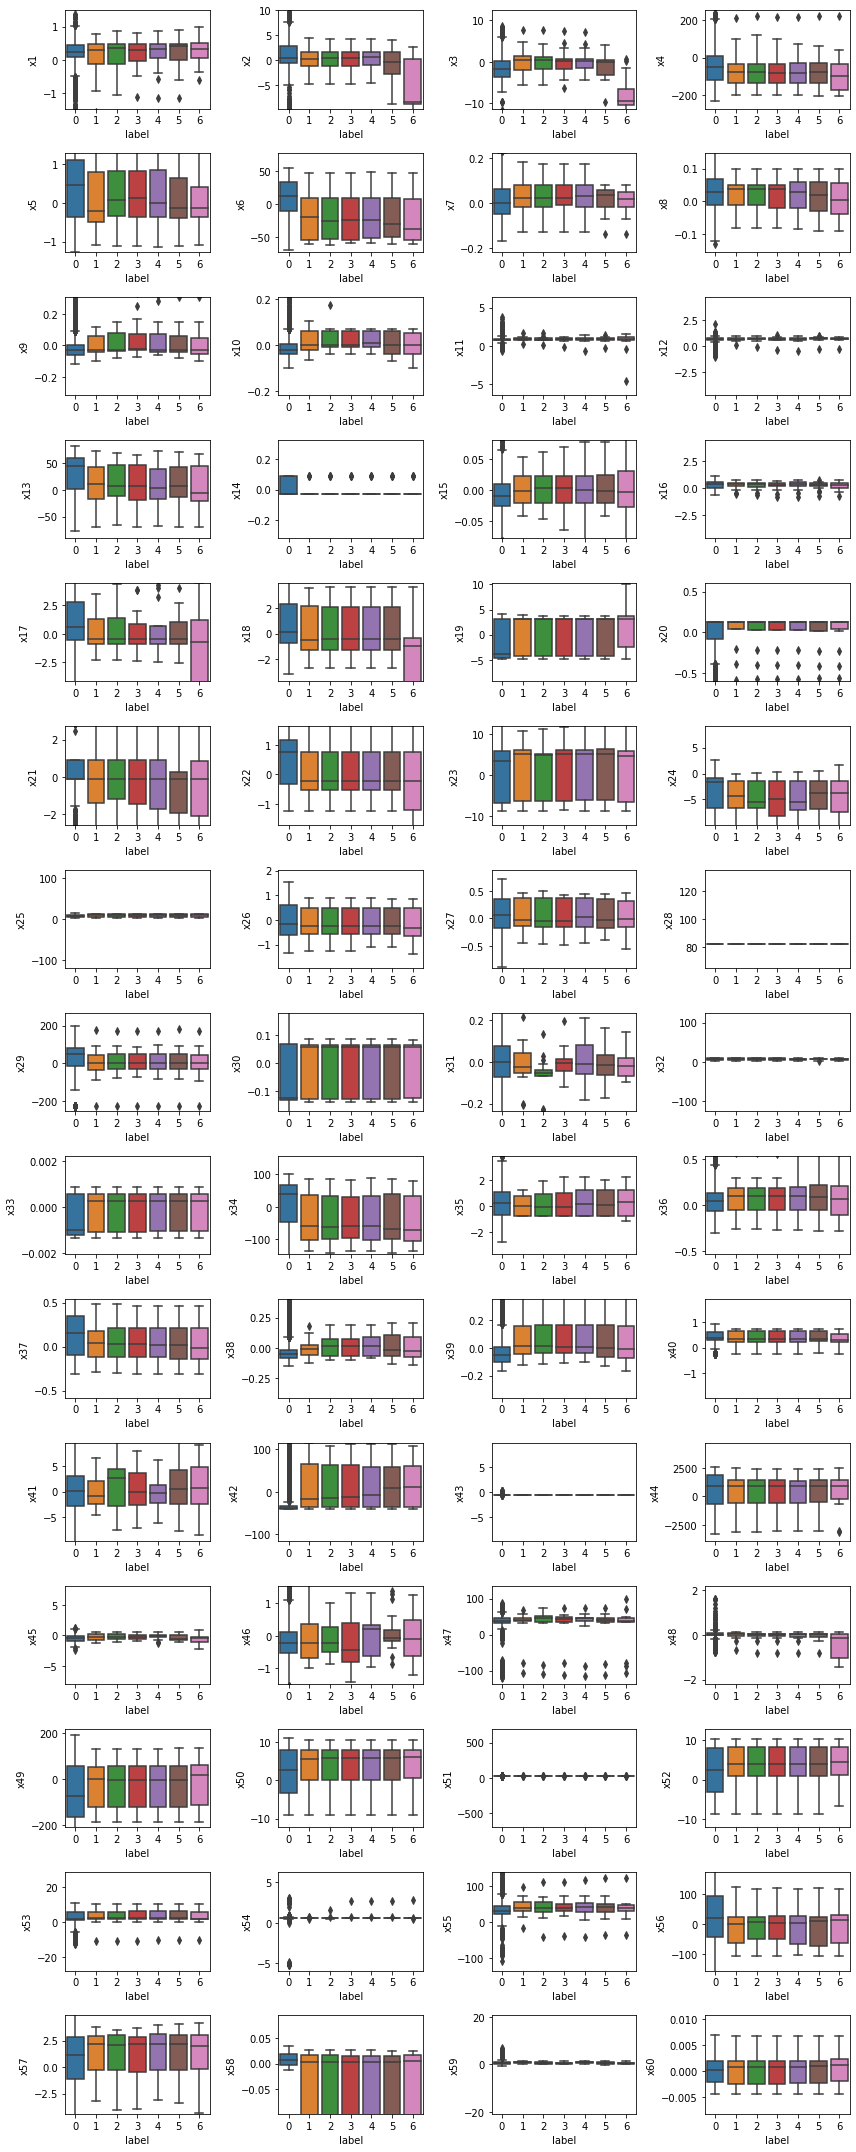

In [36]:
plt.figure(figsize=(12,30))
for i in range(60):
    feature = process_features[i]
    plt.subplot(15,4,i+1)
    plt.grid(False)
    sns.boxplot(df['label'][df['x28']==82], df[feature][df['x28']==82], saturation = 0.7)
    plt.ylim(df_stats[feature][1] - 2*df_stats[feature][2], df_stats[feature][1] + 2*df_stats[feature][2])
plt.tight_layout()

### Run a preliminary Random Forest model to screen feature importance.  This is not intended to be a final model.
Run with all samples features and again with a balanced set using fewer '0' labels 

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df[process_features], df['label'], stratify = df['label'], random_state =10)

In [39]:
X_train.shape, X_test.shape

((13798, 60), (4600, 60))

In [40]:
model = RandomForestClassifier(n_estimators = 100, max_depth = 20, random_state = 10)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [41]:
y_pred = model.predict(X_test)

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[4418,    0,    0,    0,    0,    0,    1],
       [  28,    0,    0,    0,    0,    0,    0],
       [  29,    0,    0,    1,    0,    0,    0],
       [  30,    0,    0,    0,    0,    0,    0],
       [  29,    0,    0,    1,    0,    1,    0],
       [  26,    0,    0,    1,    3,    0,    1],
       [  13,    0,    0,    0,    0,    1,   17]], dtype=int64)

The confusion matrix mislabeled most class 1 to 5 samples as class 0, and 55% of class 6 as class 0, likely driven by the highly unbalanced nature of the dataset.

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4419
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        31
           6       0.89      0.55      0.68        31

    accuracy                           0.96      4600
   macro avg       0.27      0.22      0.24      4600
weighted avg       0.93      0.96      0.95      4600



In [44]:
F_I = model.feature_importances_

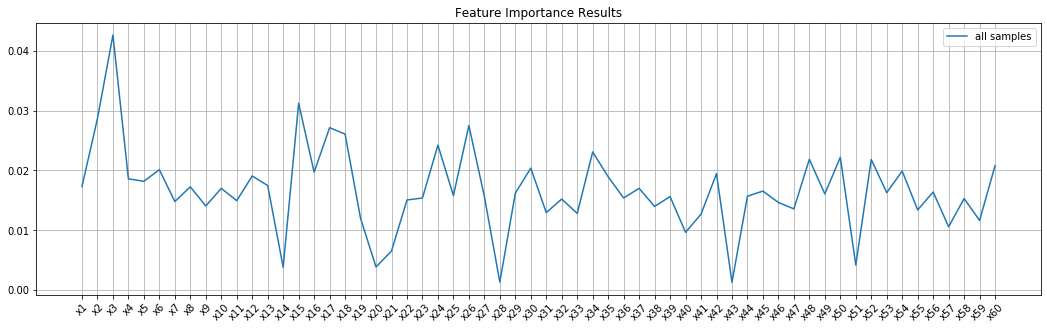

In [45]:
plt.figure(figsize=(18,5))
plt.plot(process_features,F_I, label = 'all samples')
plt.title('Feature Importance Results')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Cutting off features below 0.015 will drop about one-third of the features. 

In [46]:
# Get an undersample dataset
from sklearn.utils import shuffle

normals = df[df['label'] == 0].sample(n = 124)
labeled = df[df['label'] != 0]
df_under = pd.merge(normals, labeled, how = 'outer')
df_under = shuffle(df_under)
df_under['label'].value_counts()

6    124
5    124
0    124
4    123
3    122
2    119
1    113
Name: label, dtype: int64

#### Re-run a RF Classifier on the balanced / undersampled dataset

In [47]:
XU_train, XU_test, yu_train, yu_test = train_test_split(df_under[process_features], df_under['label'], stratify = df_under['label'], random_state =10)

In [48]:
XU_train.shape, XU_test.shape

((636, 60), (213, 60))

In [49]:
modelU = RandomForestClassifier(n_estimators = 100, max_depth = 20, random_state = 10)
modelU.fit(XU_train, yu_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [50]:
yu_pred = modelU.predict(XU_test)

In [51]:
cm_u = confusion_matrix(yu_test, yu_pred)
cm_u

array([[25,  0,  3,  0,  0,  3,  0],
       [ 1,  0, 13,  7,  5,  1,  1],
       [ 1, 10,  1, 11,  5,  2,  0],
       [ 0,  1,  9,  0, 18,  3,  0],
       [ 0,  2,  2, 16,  0, 10,  1],
       [ 0,  4,  1,  7, 13,  0,  6],
       [ 0,  0,  3,  2,  1,  6, 19]], dtype=int64)

The confusion matrix lacks accuracy for labels 1 through5, however they are mislabeled within class 1 to 5 more than classified as either 0 or 6, indicating possibly some difference or transition between normal run state and at a sheet break.

In [52]:
print(classification_report(yu_test, yu_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.00      0.00      0.00        28
           2       0.03      0.03      0.03        30
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        31
           6       0.70      0.61      0.66        31

    accuracy                           0.21       213
   macro avg       0.24      0.21      0.22       213
weighted avg       0.24      0.21      0.23       213



In [53]:
F_IU = modelU.feature_importances_

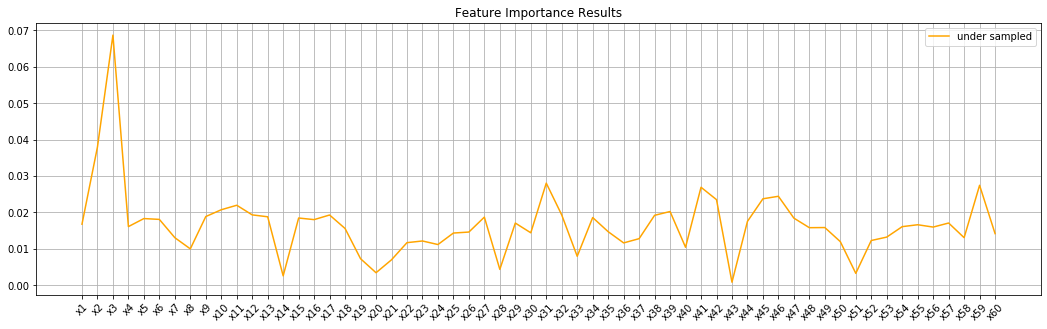

In [54]:
plt.figure(figsize=(18,5))
plt.plot(process_features,F_IU, label = 'under sampled', c='orange')
plt.title('Feature Importance Results')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Cutting off features below 0.015 will drop about half of the features. 

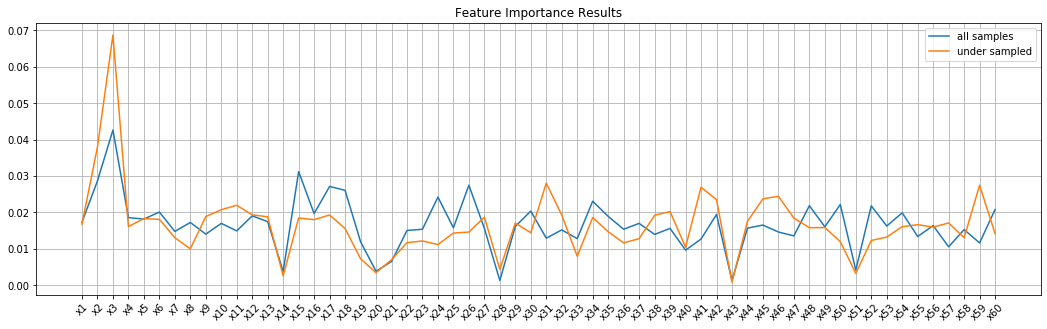

In [55]:
plt.figure(figsize=(18,5))
plt.plot(process_features,F_I, label = 'all samples')
plt.plot(process_features,F_IU, label = 'under sampled')
plt.title('Feature Importance Results')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Low importance features are consistent: x14, x20, x28, x43, x51, x61

Carry this forward into modelling efforts.